# Performing a Spatial Average using PyTecplot
Part of post-processing is taking massive amounts of data and reducing it to something that is smaller and/or quantifiable. We all know that pretty pictures look good, but it's hard to make decisions based on them.  We also know that it can be difficult to understand system performance without some sort of statistical summary of the data.

In this PyTecplot script we're going to summarize the equivalence ratio value in an internal combustion engine simulation by computing the average equivalence ratio in the Z-direction.  The result will be a single plane which contains the average of all values with respect to Z.

The equivalence ratio is defined as the ratio of the actual fuel/air ratio to the stoichiometric fuel/air ratio. Stoichiometric combustion occurs when all the oxygen is consumed in the reaction, and there is no molecular oxygen(O2) in the products. If the equivalence ratio is equal to one, the combustion is stoichiometric. If it is < 1, the combustion is lean with excess air, and if it is >1, the combustion is rich with incomplete combustion.

In the images below, you can see that we're using a diverging colormap to highlight where the equivalence ratio is equal to 1.

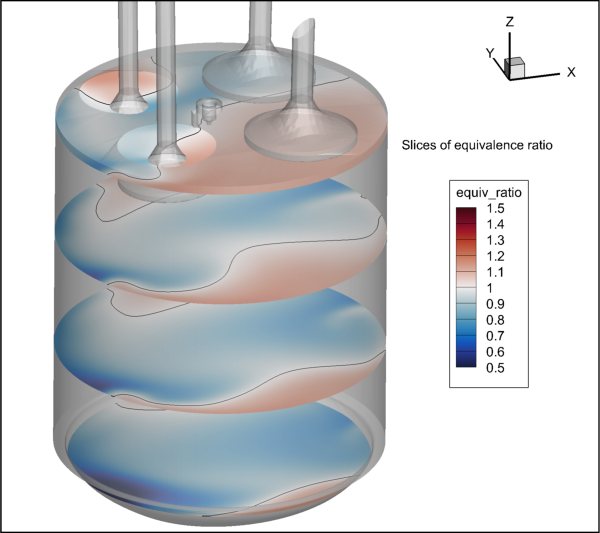

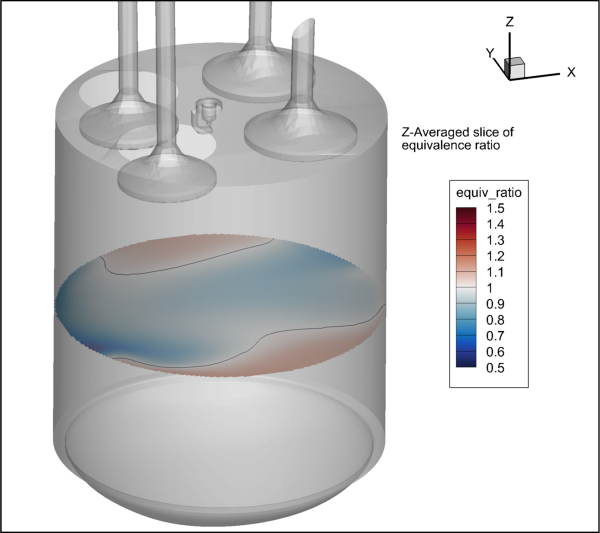

In [1]:
import numpy as np
import math
import tecplot as tp
from tecplot.constant import *
tp.load_layout("equiv_ratio.lay")
tp.extension.ipython.show()
tp.load_layout("result.lay")
tp.extension.ipython.show()

## Challenges with computing a Z-Average slice
To compute an average with respect to Z, we need 'slices' at various Z-positions and then we average across those. A prerequisite is that each slice have the same number of points, and each node on the slice be in the same XY location. Unfortunately, it's not so simple with this dataset.
1) This grid uses adaptive mesh refinement, so we're not guaranteed that each slice will have the same number of points
2) The geometry changes slightly from the cylinder head (top) to the piston (bottom). At the top, some slices may have 'cut outs' due to the geometry of the valves. At the bottom, the piston region is curved, reducing the diameter of the slice.

To overcome these challenges we'll create IJ-Planes of uniform size at regular Z-positions, linear interpolate from the volume to the IJ-Planes, and finally compute an average across the IJ-Planes.

First we'll create a couple convenience functions which will be used later in the script.

In [2]:
def create_z_plane(idim, jdim, xmin, xmax, ymin, ymax, zpos):
    tp.macro.execute_command(f'''$!CreateRectangularZone 
  IMax = {idim}
  JMax = {jdim}
  KMax = 1
  X1 = {xmin}
  Y1 = {ymin}
  Z1 = {zpos}
  X2 = {xmax}
  Y2 = {ymax}
  Z2 = {zpos}
  XVar = 1
  YVar = 2
  ZVar = 3''')
    return tp.active_frame().dataset.zone(-1)

def get_average_cell_area(zone):
    tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
        command="Calculate Function='CELLVOLUME' Normalization='None' ValueLocation='CellCentered' CalculateOnDemand='T' UseMorePointsForFEGradientCalculations='F'")
    cell_volume_var = zone.dataset.variable("Cell Volume")
    tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
        command=f"Integrate [{zone.index+1}] VariableOption='Average' ScalarVar={cell_volume_var.index+1} Absolute='F' ExcludeBlanked='F' XVariable=1 YVariable=2 ZVariable=3 IntegrateOver='Cells' IntegrateBy='Zones' PlotResults='F'")
    
    # Remove the Cell Volume variable - we don't need it in the dataset
    ds.delete_variables([ds.variable("Cell Volume")])
    
    return float(tp.active_frame().aux_data['CFDA.INTEGRATION_TOTAL'])

## Determine the IJ-Plane locations and grid density
To get an accruate result we first need to decide on the size, location, and grid density of the IJ-Planes that we're going to create. It would be easy to simply prompt the user for this information, but that's too easy. The dataset that we're using here is just a single timestep of a 720 timestep simulation. Any required user input means that we wouldn't be able to fully automate the process. So we'll attempt to automatically come up with good values for the IJ-Planes in the code below.

In this first cell, we're automatically determining the Z-positions of the IJ-Planes.

In [3]:
#Start with a fresh layout
tp.new_layout()
ds = tp.data.load_tecplot("tecplot000120.plt")

# This could be input by the user
num_sampling_planes = 20

# We know that the PISTON and LINER (aka cylinder walls) define the min/max Z-domain we want to use
zmin = ds.zone("*PISTON*").values("Z").min()
zmax = ds.zone("*LINER*").values("Z").max()

# Create sample positions, not including the min/max values
z_positions = np.linspace(zmin,zmax,num_sampling_planes+2)[1:-1]
print("Z Sampling Plane Positions", z_positions)

Z Sampling Plane Positions [-0.1045814  -0.09935233 -0.09412326 -0.08889419 -0.08366512 -0.07843605
 -0.07320698 -0.06797791 -0.06274884 -0.05751977 -0.0522907  -0.04706163
 -0.04183256 -0.03660349 -0.03137442 -0.02614535 -0.02091628 -0.01568721
 -0.01045814 -0.00522907]


### Determine the XY dimensions and grid density
This section may be a bit overkill, but we're going to extract slices at each of the Z-positions. From these slices we'll be able to determine the XY domain for the IJ-Planes.  We also use a Tecplot 360 function to determine the cell size of the slices, which we use to determine how many I/J grid points to use. This ensures that the IJ-Planes have a similar grid size to the volume grid from which we're interpolating.

In [4]:
# Extract slices to determine the maximum dimensions for the sampling plane.
# Could hardcode this or use some other cheaper method - like the X-,Y- extents of the LINER
slices = []
for zpos in z_positions:
    extracted_slice = tp.data.extract.extract_slice(origin=(0,0,zpos), normal=(0,0,1), source=SliceSource.VolumeZones)
    slices.append(extracted_slice)
    
xmin = min([zone.values('X').min() for zone in slices])
xmax = max([zone.values('X').max() for zone in slices])
ymin = min([zone.values('Y').min() for zone in slices])
ymax = max([zone.values('Y').max() for zone in slices])
print("Sampling Plane Dimensions:")
print("  XMin/XMax:", xmin, xmax)
print("  YMin/YMax:", ymin, ymax)

# Compute the average cell area of each slice and grab the minimum result to ensure
# we're capturing an appropriate amount of detail from the source volume grid.
# We could avoid this step supply an I-, J- dimension manually to speed up the script
cell_area = min([get_average_cell_area(zone) for zone in slices])
idim = int((xmax-xmin)/math.sqrt(cell_area))
jdim = int((ymax-ymin)/math.sqrt(cell_area))
print("  IDim/JMin:", idim, jdim)

Sampling Plane Dimensions:
  XMin/XMax: -0.04299899935722351 0.04299899935722351
  YMin/YMax: -0.04299816116690636 0.04299816116690636
  IDim/JMin: 153 153


## Determine which variables to average
We're going to compute the average of all the variables in the dataset which belong to the source (volume) data. So here we start with a list of all the variables in the dataset, then remove variables we don't want to average.  Clearly we should not average the spatial variables (X,Y,Z).  We can also save some time by omitting 'passive' variables. Tecplot 360 requires that all zones define all variables - but variables marked as 'passive' effectively don't exist in the dataset. Removing these from the interpolation and average step will save some computation time.

In [5]:
vars_to_average = list(ds.variables())
# Don't average the grid variables
vars_to_average.remove(ds.variable(0))
vars_to_average.remove(ds.variable(1))
vars_to_average.remove(ds.variable(2))

source_zone = ds.zone("*Cell Data*")
# Remove passive variables from the vars_to_average
for v in ds.variables():
    if source_zone.values(v).passive:
        vars_to_average.remove(v)

print("Average will be computed for these variables:", [v.name for v in vars_to_average])

Average will be computed for these variables: ['mass', 'pressure', 'temp', 'Vel_U', 'Vel_V', 'Vel_W', 'Vel_mag', 'equiv_ratio', 'yIC8H18', 'yO2', 'yCO2', 'INTAKE', 'EXHAUST', 'CYLINDER', 'eps', 'tke']


## Creating the sampling IJ-planes
The IJ-Planes we're creating are rectangular but are sampling from the circular region. Furthermore, some of the sampling planes may have holes in them (due to the placement of the valves) or be smaller than the others (due to being in the region of the piston bowl).  Because of this we need to avoid including those regions when doing our subsequent averaging. To help with this we're going to create a 'Blank' variable, which we'll not only be able to use for plotting, but also to mask out the points that shouldn't be included in the average calculation.

Here we add the 'Blank' variable - ensuring we also include it in the set of variables to average. We then, for each z-position, create an IJ-Plane and interpolate the values from the source (volume) zone on to the IJ-Plane.

Notice that we use the fill_value parameter to assign the mask value to areas of the IJ-Plane that are not within the source volume grid. 

Interpolating values at: -0.10458140146164667
Interpolating values at: -0.09935233138856434
Interpolating values at: -0.094123261315482
Interpolating values at: -0.08889419124239967
Interpolating values at: -0.08366512116931733
Interpolating values at: -0.078436051096235
Interpolating values at: -0.07320698102315268
Interpolating values at: -0.06797791095007033
Interpolating values at: -0.06274884087698801
Interpolating values at: -0.05751977080390567
Interpolating values at: -0.052290700730823335
Interpolating values at: -0.04706163065774101
Interpolating values at: -0.04183256058465867
Interpolating values at: -0.03660349051157634
Interpolating values at: -0.031374420438494005
Interpolating values at: -0.02614535036541167
Interpolating values at: -0.020916280292329337
Interpolating values at: -0.015687210219247003
Interpolating values at: -0.010458140146164668
Interpolating values at: -0.005229070073082334


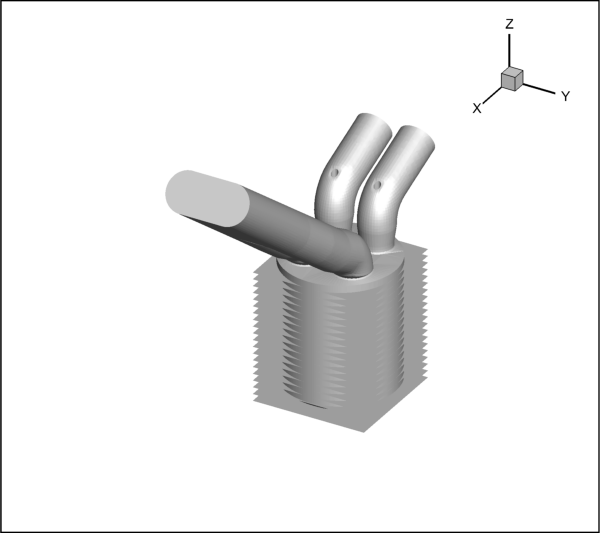

In [6]:
# Create a blanking or 'mask' variable to be used by the averaging routine later on.
tp.data.operate.execute_equation("{Blank} = 0")
vars_to_average.append(ds.variable('Blank'))

blanking_value = 1
zones_to_average = []
for zpos in z_positions:
    zone = create_z_plane(idim,jdim,xmin,xmax,ymin,ymax,zpos)
    zone.name = f"Interpolation Plane Z={zpos}"
    print("Interpolating values at:", zpos)
    tp.data.operate.interpolate_linear(zone, source_zones=[source_zone], variables=vars_to_average, fill_value=blanking_value)
    zones_to_average.append(zone)
    
tp.extension.ipython.show()

## Create the IJ-Plane to hold the results
Now that the sampling planes have been created, and the variables have been interpolated onto them, we'll create one final IJ-Plane which will hold the result.

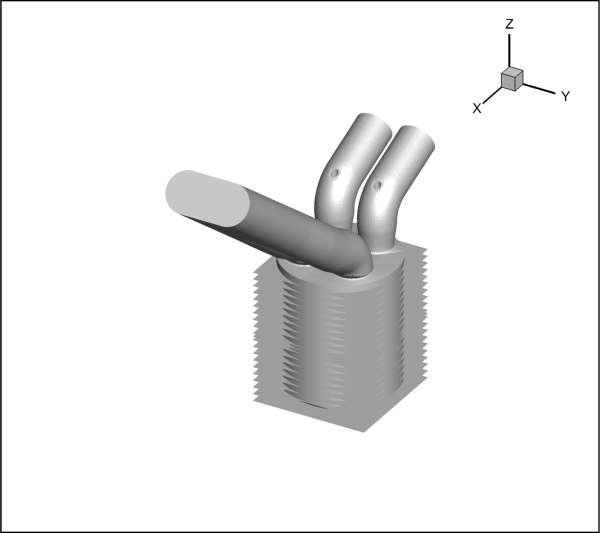

In [7]:
# Create the result zone at an average Z-position
result_z_pos = ((z_positions[-1] - z_positions[0])/2.) + z_positions[0]
result_zone = create_z_plane(idim,jdim,xmin,xmax,ymin,ymax,result_z_pos)
result_zone.name = "Mean"

tp.extension.ipython.show()

## Use numpy to compute the spatial average
We have everything we need to finally compute the spatial average, now we just need to do it. Here we're using a numpy masked array when computing the average.  As mentioned above, there may be regions of the IJ-Plane that do not pass through volume cells - these regions will have a value of 1 (the blanking_value variable defined above). This blanking value is used in creating a mask array, which numpy knows to discard from the average calculation.

Note that we avoid using the mask when transferring the 'Blank' value - this allows us to use the 'Blank' variable for plotting.

In [8]:
for var in vars_to_average:
    print("Computing average for:", var.name)
    if var.name == 'Blank':
        # Don't mask the 'Blank' variable, since we want all values to come
        # through to the result zone so we can use Value Blanking
        data = np.array([z.values(var)[:] for z in zones_to_average])
    else:
        data = np.ma.masked_array([z.values(var)[:] for z in zones_to_average], 
                                  [z.values('Blank')[:] == 1 for z in zones_to_average])
    result_zone.values(var)[:] = np.average(data, axis=0)
    
# Save the result to a file for future use
tp.data.save_tecplot_plt("result.plt", zones=[result_zone])

Computing average for: mass
Computing average for: pressure
Computing average for: temp
Computing average for: Vel_U
Computing average for: Vel_V
Computing average for: Vel_W
Computing average for: Vel_mag
Computing average for: equiv_ratio
Computing average for: yIC8H18
Computing average for: yO2
Computing average for: yCO2
Computing average for: INTAKE
Computing average for: EXHAUST
Computing average for: CYLINDER
Computing average for: eps
Computing average for: tke
Computing average for: Blank


Dataset(uid=413, frame=Frame(uid=404, page=Page(uid=395)))

## The final result
Finally, we'll load precreated layouts file, which use the result.plt file that we saved above. The first image below is our original layout with slices of equivalence ratio. The second image is the spatial averaged result. The final image is of our average plane, showing the effect of masking the results.

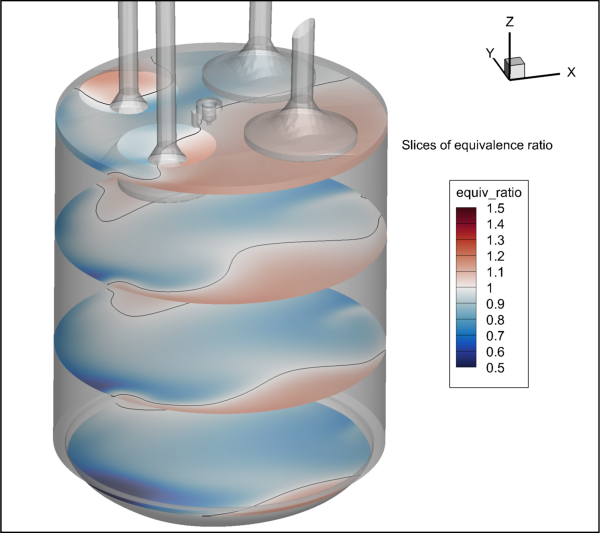

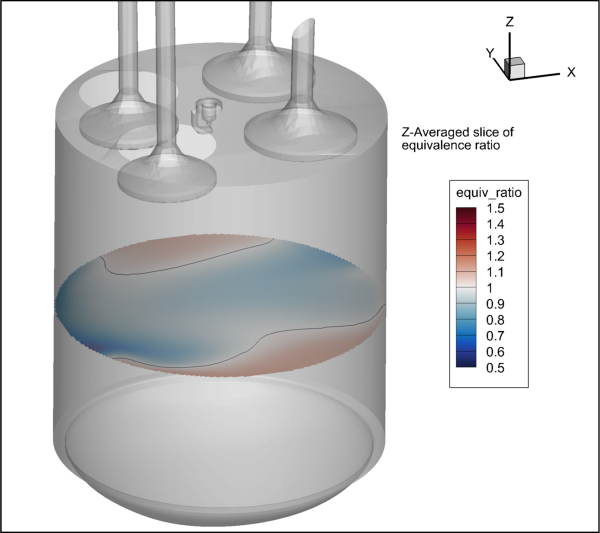

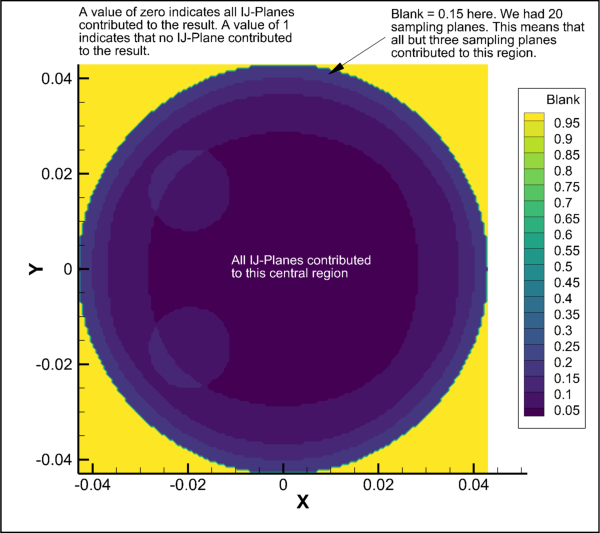

In [9]:
tp.load_layout("equiv_ratio.lay")
tp.extension.ipython.show()
tp.load_layout("result.lay")
tp.extension.ipython.show()
tp.load_layout("result2.lay")
tp.extension.ipython.show()